Epoch 1/20, Loss: 0.8333
Epoch 2/20, Loss: 0.1731
Epoch 3/20, Loss: 0.0449
Epoch 4/20, Loss: 0.0271
Epoch 5/20, Loss: 0.0238
Epoch 6/20, Loss: 0.0200
Epoch 7/20, Loss: 0.0198
Epoch 8/20, Loss: 0.0178
Epoch 9/20, Loss: 0.0167
Epoch 10/20, Loss: 0.0196
Epoch 11/20, Loss: 0.0178
Epoch 12/20, Loss: 0.0149
Epoch 13/20, Loss: 0.0141
Epoch 14/20, Loss: 0.0137
Epoch 15/20, Loss: 0.0129
Epoch 16/20, Loss: 0.0140
Epoch 17/20, Loss: 0.0129
Epoch 18/20, Loss: 0.0133
Epoch 19/20, Loss: 0.0130
Epoch 20/20, Loss: 0.0139


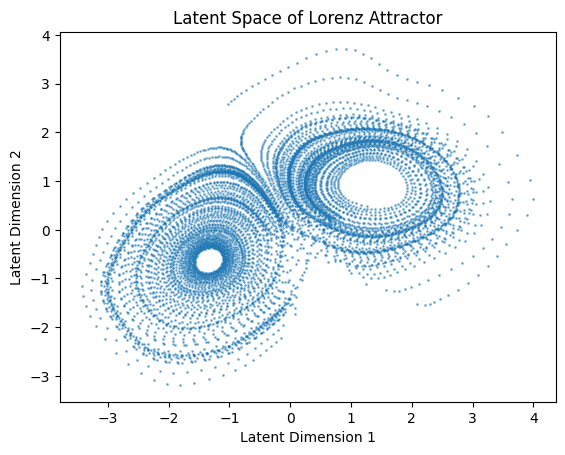

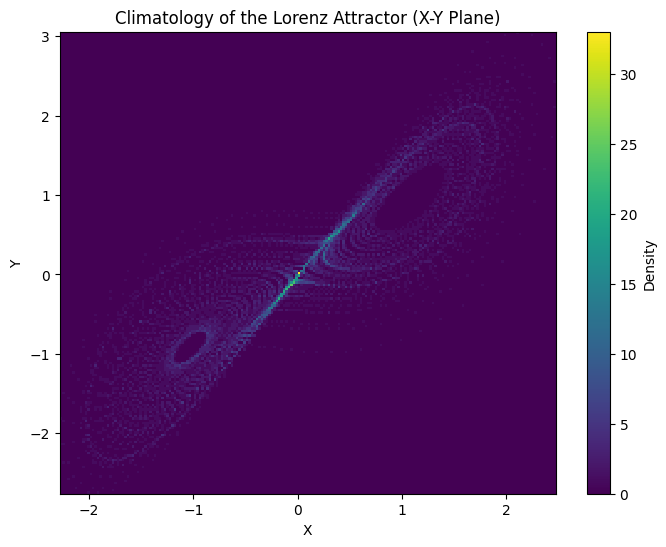

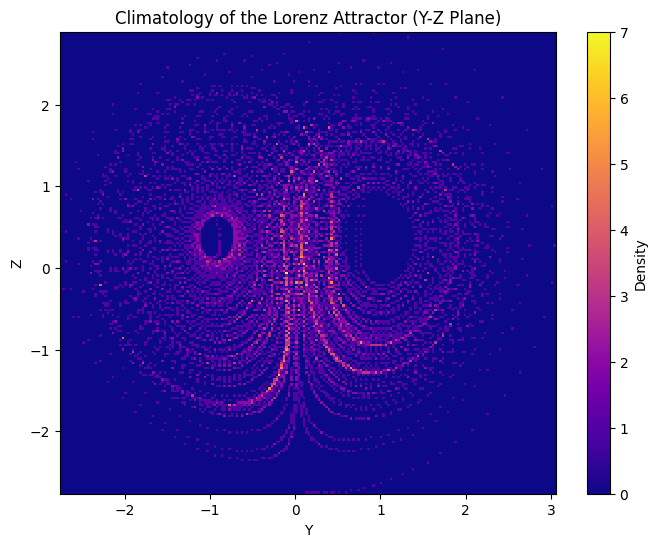

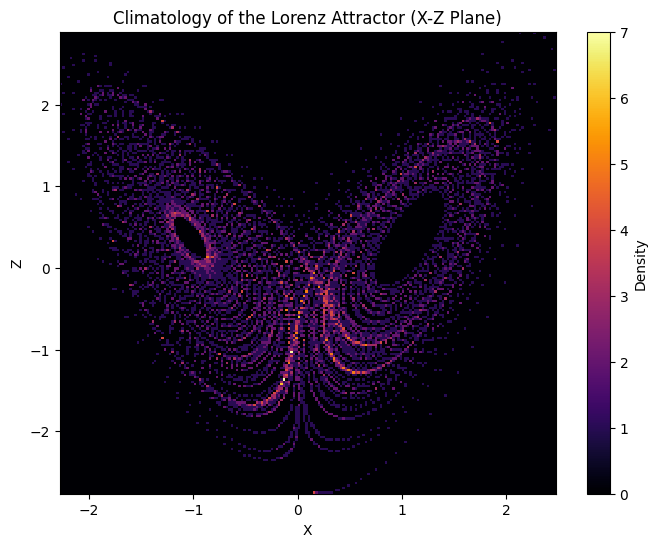

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# --- Data Preparation ---
# Generate Lorenz attractor or any time-series data
from scipy.integrate import solve_ivp

# Function to generate Lorenz attractor
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Generate Lorenz data
t_span = (0, 100)
initial_state = [1, 1, 1]
t_eval = np.linspace(0, 100, 10000)
solution = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval)
data = np.array(solution.y).T  # Shape: (10000, 3)

# Normalize the data
data = (data - data.mean(axis=0)) / data.std(axis=0)

# Prepare sequences for RNN
seq_len = 20  # Number of timesteps per sequence
sequences = [data[i:i + seq_len] for i in range(len(data) - seq_len)]
sequences = torch.tensor(sequences, dtype=torch.float32)

# DataLoader for training
train_ratio = 0.8
train_size = int(len(sequences) * train_ratio)

train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

train_loader = DataLoader(TensorDataset(train_sequences), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(test_sequences), batch_size=64, shuffle=False)

# --- Model Definition ---
# Encoder with LSTM
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=64):
        super(EncoderRNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)  # Last hidden state
        h = hidden.squeeze(0)          # Shape: (batch_size, hidden_dim)
        mu = self.fc_mu(h)             # Mean vector
        logvar = self.fc_logvar(h)     # Log-variance vector
        return mu, logvar

# Decoder with LSTM
class DecoderRNN(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim=64):
        super(DecoderRNN, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, seq_len):
        h = torch.relu(self.fc(z))        # Map latent space to hidden space
        h = h.unsqueeze(1).repeat(1, seq_len, 1)  # Repeat for sequence length
        out, _ = self.lstm(h)             # LSTM outputs the sequence
        return self.fc_out(out)           # Map back to original space

# VAE with LSTM
class VAE_RNN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=64):
        super(VAE_RNN, self).__init__()
        self.encoder = EncoderRNN(input_dim, latent_dim, hidden_dim)
        self.decoder = DecoderRNN(latent_dim, input_dim, hidden_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)    # Standard deviation
        eps = torch.randn_like(std)     # Random noise
        return mu + eps * std           # Reparameterization trick

    def forward(self, x):
        mu, logvar = self.encoder(x)           # Encode input sequence
        z = self.reparameterize(mu, logvar)    # Sample from latent space
        recon_x = self.decoder(z, x.size(1))   # Decode sequence
        return recon_x, mu, logvar

# --- Loss Function ---
# Assign higher weights to reconstruction errors at later timesteps during training.
def vae_loss(recon_x, x, mu, logvar, kl_weight=0.001):
    seq_len = x.size(1)
    weights = torch.linspace(1.0, 2.0, seq_len).to(x.device)  # Linearly increasing weights
    recon_loss = ((recon_x - x)**2 * weights.unsqueeze(0).unsqueeze(-1)).mean()  # Weighted MSE
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kl_weight * kld

# --- Training ---
input_dim = data.shape[1]  # Number of features (3 for Lorenz attractor)
latent_dim = 2             # Latent space dimensionality
hidden_dim = 64            # Hidden dimension of LSTM
learning_rate = 1e-3
epochs = 20

vae_rnn = VAE_RNN(input_dim, latent_dim, hidden_dim)
optimizer = optim.Adam(vae_rnn.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        x = batch[0]  # Input batch
        recon_x, mu, logvar = vae_rnn(x)  # Forward pass
        loss = vae_loss(recon_x, x, mu, logvar)  # Compute loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# --- Visualization of Latent Space ---
with torch.no_grad():
    all_mu = []
    for batch in train_loader:
        x = batch[0]
        mu, _ = vae_rnn.encoder(x)
        all_mu.append(mu)
    all_mu = torch.cat(all_mu, dim=0).numpy()

plt.scatter(all_mu[:, 0], all_mu[:, 1], alpha=0.5, s=1)
plt.title("Latent Space of Lorenz Attractor")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

# --- Climatology Plot ---

# 2D Histogram (Density Plot) in X-Y Plane
plt.figure(figsize=(8, 6))
plt.hist2d(data[:, 0], data[:, 1], bins=200, cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Climatology of the Lorenz Attractor (X-Y Plane)')
plt.show()

# 2D Histogram in Y-Z Plane
plt.figure(figsize=(8, 6))
plt.hist2d(data[:, 1], data[:, 2], bins=200, cmap='plasma')
plt.colorbar(label='Density')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Climatology of the Lorenz Attractor (Y-Z Plane)')
plt.show()

# 2D Histogram in X-Z Plane
plt.figure(figsize=(8, 6))
plt.hist2d(data[:, 0], data[:, 2], bins=200, cmap='inferno')
plt.colorbar(label='Density')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Climatology of the Lorenz Attractor (X-Z Plane)')
plt.show()




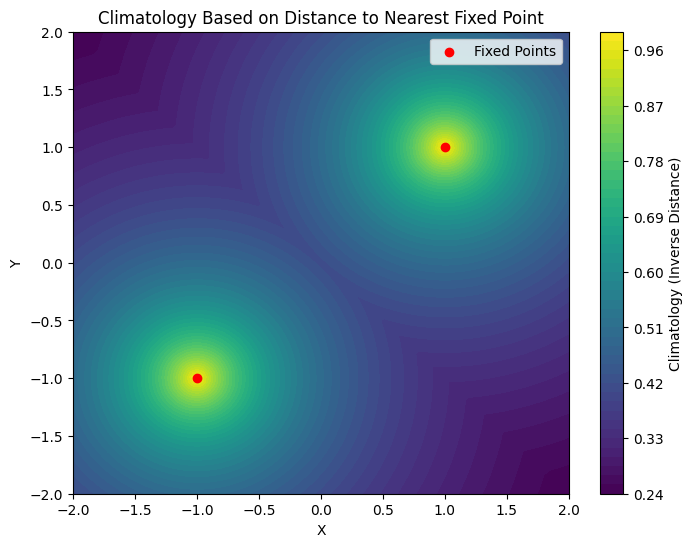

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the fixed points
fixed_points = np.array([[1, 1], [-1, -1]])  # Example: two fixed points in 2D

# Generate a grid of points in the phase space
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)  # Flattened grid points

# Calculate the distance to the nearest fixed point for each grid point
distances = np.min(
    np.linalg.norm(grid_points[:, np.newaxis, :] - fixed_points[np.newaxis, :, :], axis=-1),
    axis=1
)

# Define the "climatology" as inversely proportional to the distance
climatology = 1 / (1 + distances)
climatology = climatology.reshape(X.shape)  # Reshape to grid for plotting

# Plot the climatology as a heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, climatology, levels=50, cmap="viridis")
plt.colorbar(label="Climatology (Inverse Distance)")
plt.scatter(fixed_points[:, 0], fixed_points[:, 1], color="red", label="Fixed Points", zorder=5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Climatology Based on Distance to Nearest Fixed Point")
plt.legend()
plt.show()


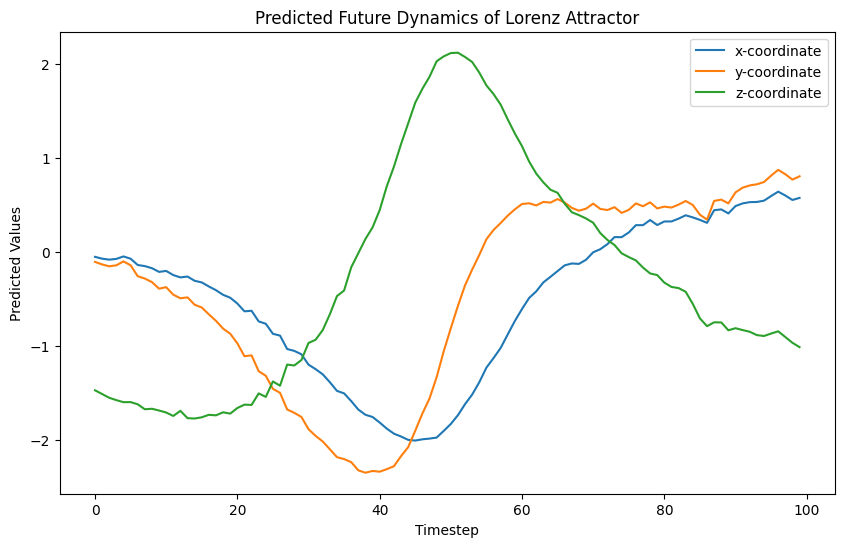

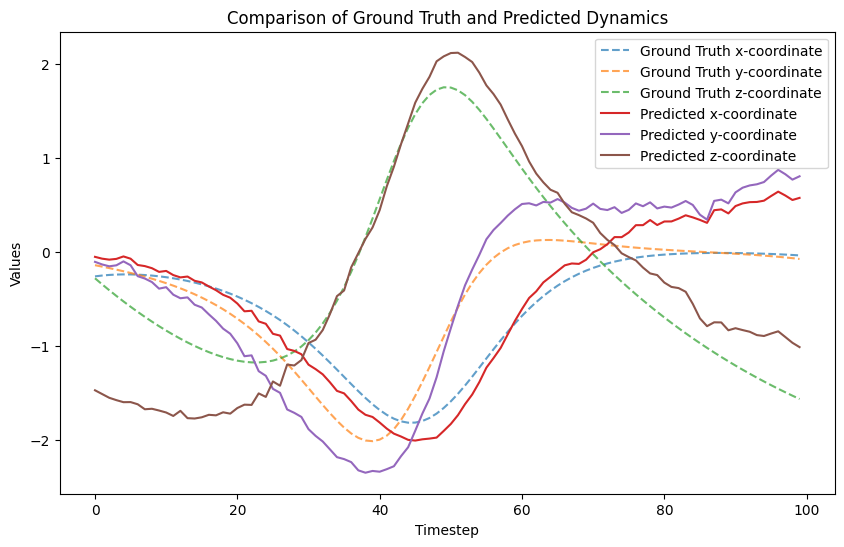

In [ ]:
def predict_future(vae_rnn, initial_sequence, steps=100):
    predicted = []
    current_sequence = initial_sequence.unsqueeze(0)  # Add batch dimension (1, seq_len, feature_dim)

    for _ in range(steps):
        with torch.no_grad():
            # Forward pass through the VAE-RNN
            recon_x, _, _ = vae_rnn(current_sequence)

            # Extract the last predicted step from the output sequence
            predicted_step = recon_x[:, -1, :]  # Shape: (batch_size, feature_dim)

            # Append the predicted step to the list
            predicted.append(predicted_step.squeeze(0).numpy())  # Remove batch dimension

            # Update current sequence by shifting and appending the new step
            current_sequence = torch.cat([current_sequence[:, 1:, :], predicted_step.unsqueeze(1)], dim=1)

    return np.array(predicted)


# Initial sequence (last 10 steps of data)
initial_sequence = sequences[-1]
predicted_future = predict_future(vae_rnn, initial_sequence, steps=100)

# Plot all predicted features
plt.figure(figsize=(10, 6))
plt.plot(predicted_future[:, 0], label="x-coordinate")
plt.plot(predicted_future[:, 1], label="y-coordinate")
plt.plot(predicted_future[:, 2], label="z-coordinate")
plt.title("Predicted Future Dynamics of Lorenz Attractor")
plt.xlabel("Timestep")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

ground_truth = data[-100:]  # Last 100 steps from your dataset
plt.figure(figsize=(10, 6))

# Plot ground truth
plt.plot(ground_truth[:, 0], label="Ground Truth x-coordinate", linestyle='--', alpha=0.7)
plt.plot(ground_truth[:, 1], label="Ground Truth y-coordinate", linestyle='--', alpha=0.7)
plt.plot(ground_truth[:, 2], label="Ground Truth z-coordinate", linestyle='--', alpha=0.7)

# Plot predictions
plt.plot(predicted_future[:, 0], label="Predicted x-coordinate")
plt.plot(predicted_future[:, 1], label="Predicted y-coordinate")
plt.plot(predicted_future[:, 2], label="Predicted z-coordinate")

plt.title("Comparison of Ground Truth and Predicted Dynamics")
plt.xlabel("Timestep")
plt.ylabel("Values")
plt.legend()
plt.show()



In [ ]:
def time_to_next_jump(predicted_trajectory):
    """
    Calculates the number of timestamps it takes for the trajectory to jump from one wing to another.

    Parameters:
    - predicted_trajectory: numpy array of shape (timesteps, 3), where the first column is the x-coordinate.

    Returns:
    - timestamps_to_jump: Number of timestamps to the next wing jump, or -1 if no jump is detected.
    """
    x_values = predicted_trajectory[:, 0]  # Extract x-coordinate (first column)

    # Find the initial sign of the x-coordinate
    initial_sign = np.sign(x_values[0])

    # Iterate through the trajectory to detect the first sign change
    for t in range(1, len(x_values)):
        if np.sign(x_values[t]) != initial_sign:
            return t  # Return the timestamp when the sign changes

    return -1  # Return -1 if no jump is detected within the given trajectory

# Example trajectory (predicted_future from the VAE-RNN model)
predicted_trajectory = predict_future(vae_rnn, initial_sequence, steps=100)

# Calculate time to the next jump
timestamps_to_jump = time_to_next_jump(predicted_trajectory)

if timestamps_to_jump != -1:
    print(f"The system will jump to the other wing in {timestamps_to_jump} timestamps.")
else:
    print("No wing jump detected in the given trajectory.")


def detect_all_jumps(predicted_trajectory):
    """
    Detects all wing jumps in the trajectory and returns their timestamps.

    Parameters:
    - predicted_trajectory: numpy array of shape (timesteps, 3), where the first column is the x-coordinate.

    Returns:
    - jumps: List of timestamps where wing jumps occur.
    """
    x_values = predicted_trajectory[:, 0]  # Extract x-coordinate
    jumps = []

    # Iterate through the trajectory to detect sign changes
    for t in range(1, len(x_values)):
        if np.sign(x_values[t]) != np.sign(x_values[t - 1]):  # Check for sign change
            jumps.append(t)

    return jumps
# Detect all wing jumps
jumps = detect_all_jumps(predicted_trajectory)
print(f"Wing jumps occur at timestamps: {jumps}")


The system will jump to the other wing in 71 timestamps.
Wing jumps occur at timestamps: [71]


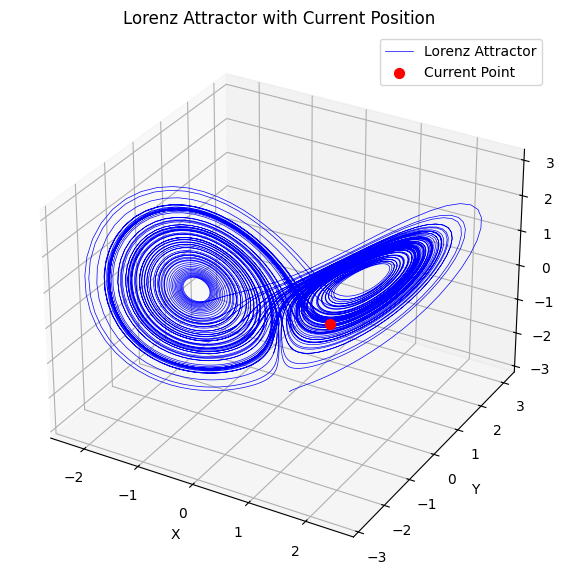

You are currently on the **right wing** of the Lorenz attractor (x > 0).


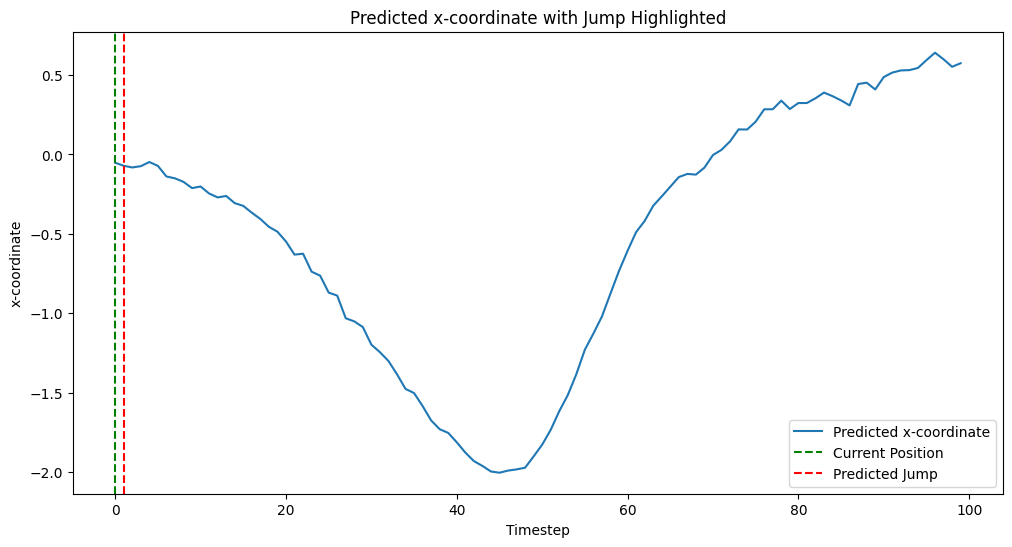

In [ ]:
# If using the original data
current_point = data[-1]  # Last point in your dataset

# If using predicted data
current_point = predicted_future[-1]  # Last predicted point
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, z from data
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Get current point
current_x = current_point[0]
current_y = current_point[1]
current_z = current_point[2]

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the Lorenz attractor trajectory
ax.plot(x, y, z, lw=0.5, color='blue', label='Lorenz Attractor')

# Plot the current point
ax.scatter(current_x, current_y, current_z, color='red', s=50, label='Current Point')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor with Current Position')
ax.legend()

plt.show()
if current_point[0] > 0:
    print("You are currently on the **right wing** of the Lorenz attractor (x > 0).")
else:
    print("You are currently on the **left wing** of the Lorenz attractor (x < 0).")
# Plot predicted x-coordinate over time
plt.figure(figsize=(12, 6))
plt.plot(predicted_future[:, 0], label='Predicted x-coordinate')

# Mark the current position
plt.axvline(x=0, color='green', linestyle='--', label='Current Position')

# Mark the predicted jump
jump_time = timestamps_to_jump  # From your earlier calculation
if jump_time != -1:
    plt.axvline(x=jump_time, color='red', linestyle='--', label='Predicted Jump')

plt.title('Predicted x-coordinate with Jump Highlighted')
plt.xlabel('Timestep')
plt.ylabel('x-coordinate')
plt.legend()
plt.show()


Current Position: x = -0.03707339222062477, y = -0.07478156423669097, z = -1.5613831088917145
Predicted Position after 32 timesteps: x = -1.3539423942565918, y = -2.0618722438812256, z = -0.7098493576049805


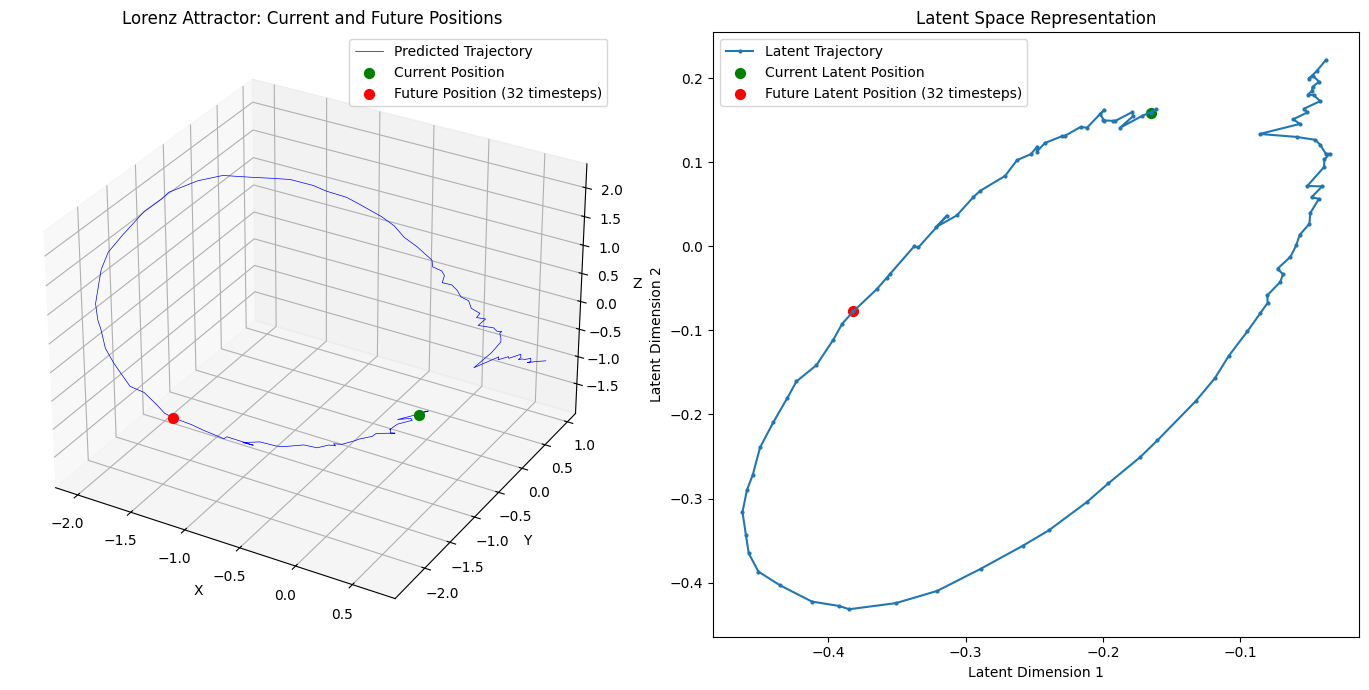

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def visualize_future_position(current_point, predicted_trajectory, vae_rnn=None, future_timestep=32):
    """
    Visualizes the current position and the predicted position after a specified number of timesteps
    in both the original Lorenz attractor space and the latent space (if VAE-RNN is provided).

    Parameters:
    - current_point: numpy array of shape (3,), the current position in (x, y, z).
    - predicted_trajectory: numpy array of shape (timesteps, 3), predicted future trajectory.
    - vae_rnn: Trained VAE-RNN model (optional). If provided, visualizes latent space representation.
    - future_timestep: Number of timesteps into the future to visualize the predicted position.
    """
    # Validate inputs
    if future_timestep >= len(predicted_trajectory):
        print("Error: future_timestep exceeds the length of the predicted trajectory.")
        return

    # Current and future positions
    future_position = predicted_trajectory[future_timestep]
    print(f"Current Position: x = {current_point[0]}, y = {current_point[1]}, z = {current_point[2]}")
    print(f"Predicted Position after {future_timestep} timesteps: x = {future_position[0]}, y = {future_position[1]}, z = {future_position[2]}")

    # 3D Plot: Lorenz attractor space
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(121, projection='3d')

    # Plot predicted trajectory
    ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], predicted_trajectory[:, 2], lw=0.5, color='blue', label='Predicted Trajectory')

    # Plot current and future positions
    ax.scatter(current_point[0], current_point[1], current_point[2], color='green', s=50, label='Current Position')
    ax.scatter(future_position[0], future_position[1], future_position[2], color='red', s=50, label=f'Future Position ({future_timestep} timesteps)')

    # Add labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Lorenz Attractor: Current and Future Positions')
    ax.legend()

    # Latent Space Plot (if VAE-RNN is provided)
    if vae_rnn is not None:
        with torch.no_grad():
            latent_points = []
            for step in predicted_trajectory:
                step_tensor = torch.tensor(step, dtype=torch.float32).unsqueeze(0)
                mu, _ = vae_rnn.encoder(step_tensor)
                latent_points.append(mu.numpy())

        latent_points = np.array(latent_points)

        # Get latent representation of current and future points
        latent_current = latent_points[0]
        latent_future = latent_points[future_timestep]

        # Plot latent space trajectory
        ax2 = fig.add_subplot(122)
        ax2.plot(latent_points[:, 0], latent_points[:, 1], '-o', markersize=2, label='Latent Trajectory')
        ax2.scatter(latent_current[0], latent_current[1], color='green', s=50, label='Current Latent Position')
        ax2.scatter(latent_future[0], latent_future[1], color='red', s=50, label=f'Future Latent Position ({future_timestep} timesteps)')
        ax2.set_xlabel('Latent Dimension 1')
        ax2.set_ylabel('Latent Dimension 2')
        ax2.set_title('Latent Space Representation')
        ax2.legend()

    plt.tight_layout()
    plt.show()
# Example current point
current_point = data[-1]  # Last point in original dataset

# Predicted future trajectory (from your VAE-RNN)
predicted_trajectory = predict_future(vae_rnn, initial_sequence, steps=100)

# Visualize current and future positions
visualize_future_position(current_point=current_point,
                          predicted_trajectory=predicted_trajectory,
                          vae_rnn=vae_rnn,  # Pass None if you don't need latent space
                          future_timestep=32)


The Lorenz attractor is a toy example where we know the equations. But in many real-world systems (e.g., turbulence in weather, stock markets, biological systems), we don’t know the exact equations.
A machine learning model can learn patterns directly from data, even if we don’t know the underlying rules.

Solving equations like the Lorenz system numerically can be computationally expensive, especially for large-scale systems (e.g., fluid dynamics simulations).
Once trained, a machine learning model can make predictions almost instantly because it skips solving the equations step by step.

The Lorenz equations assume we know the exact initial conditions. In real-world systems, we have noisy, incomplete, or imperfect data.
Machine learning models can learn to handle noise and make reasonable predictions, while numerical methods would diverge quickly with bad data.

A trained model can potentially generalize to similar chaotic systems (e.g., the Rössler attractor or even experimental data from nature).
You could use the model on systems where the equations aren’t exactly the same but share common behaviors.

The latent space in a Variational Autoencoder (VAE) compresses the system into a simpler, lower-dimensional form. This helps us analyze and understand the system in new ways.
For example, you can explore how "wing shifts" in the Lorenz attractor appear in the latent space.

This is why machine learning can’t yet replace equations for highly accurate results, but it’s useful for specific tasks like pattern recognition, noise handling, or real-time predictions.

In [ ]:
def compare_with_ground_truth(current_point, predicted_trajectory, ground_truth, future_timestep=32):
    """
    Compares the predicted position with the ground truth after a specified number of timesteps.
    Visualizes the comparison in 3D space and calculates the error.

    Parameters:
    - current_point: numpy array of shape (3,), the current position in (x, y, z).
    - predicted_trajectory: numpy array of shape (timesteps, 3), predicted future trajectory.
    - ground_truth: numpy array of shape (timesteps, 3), ground truth trajectory.
    - future_timestep: Number of timesteps into the future to compare.

    Returns:
    - error: Euclidean distance between predicted position and ground truth at the specified timestep.
    """
    # Validate inputs
    if future_timestep >= len(predicted_trajectory) or future_timestep >= len(ground_truth):
        print("Error: future_timestep exceeds the length of the trajectories.")
        return None

    # Predicted and ground truth positions
    predicted_position = predicted_trajectory[future_timestep]
    true_position = ground_truth[future_timestep]

    # Calculate Euclidean distance
    error = np.linalg.norm(predicted_position - true_position)
    print(f"Current Position: x = {current_point[0]}, y = {current_point[1]}, z = {current_point[2]}")
    print(f"Predicted Position after {future_timestep} timesteps: x = {predicted_position[0]}, y = {predicted_position[1]}, z = {predicted_position[2]}")
    print(f"Ground Truth Position after {future_timestep} timesteps: x = {true_position[0]}, y = {true_position[1]}, z = {true_position[2]}")
    print(f"Prediction Error (Euclidean Distance): {error:.4f}")

    # 3D Plot: Predicted vs Ground Truth
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot predicted trajectory
    ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], predicted_trajectory[:, 2], lw=0.5, color='blue', label='Predicted Trajectory')

    # Plot ground truth trajectory
    ax.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], lw=0.5, color='orange', label='Ground Truth Trajectory')

    # Plot current, predicted, and ground truth positions
    ax.scatter(current_point[0], current_point[1], current_point[2], color='green', s=50, label='Current Position')
    ax.scatter(predicted_position[0], predicted_position[1], predicted_position[2], color='red', s=50, label=f'Predicted Position ({future_timestep} timesteps)')
    ax.scatter(true_position[0], true_position[1], true_position[2], color='purple', s=50, label=f'Ground Truth Position ({future_timestep} timesteps)')

    # Add labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Comparison of Predicted and Ground Truth Positions')
    ax.legend()

    plt.show()

    return error


Current Position: x = -0.2597206133070351, y = -0.14103165601748407, z = -0.28003060367138016
Predicted Position after 32 timesteps: x = -1.1605397462844849, y = -1.848311185836792, z = -1.0504947900772095
Ground Truth Position after 32 timesteps: x = -1.100158430055773, y = -1.6249633460874366, z = -0.7599479821913444
Prediction Error (Euclidean Distance): 0.3714


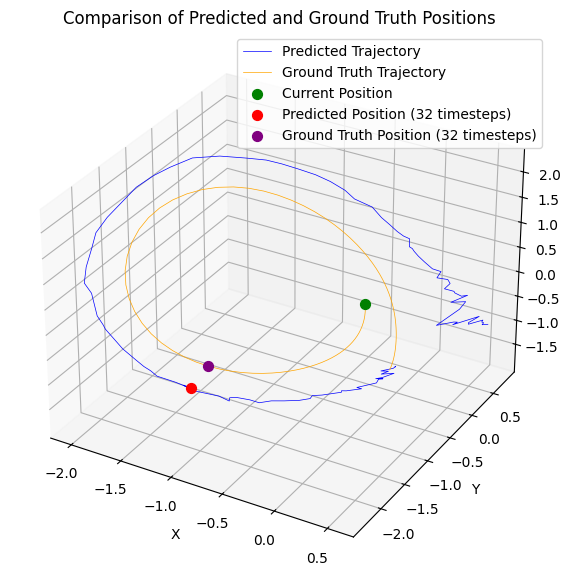

Error after 32 timesteps: 0.3714


In [ ]:
# Example current point
current_point = data[-100]  # Starting from a specific point in the original dataset

# Predicted future trajectory (from your VAE-RNN)
predicted_trajectory = predict_future(vae_rnn, initial_sequence, steps=100)

# Ground truth trajectory for the same future period
ground_truth = data[-100:]  # The next 100 steps from the original data

# Compare the prediction with the ground truth
error = compare_with_ground_truth(current_point=current_point,
                                  predicted_trajectory=predicted_trajectory,
                                  ground_truth=ground_truth,
                                  future_timestep=32)

print(f"Error after 32 timesteps: {error:.4f}")


In [ ]:
def evaluate_prediction_accuracy(current_point, predicted_trajectory, ground_truth, max_timesteps=100):
    """
    Evaluates the accuracy of predictions against ground truth over multiple timesteps.
    Plots the error over time and visualizes trajectories in 3D space.

    Parameters:
    - current_point: numpy array of shape (3,), the current position in (x, y, z).
    - predicted_trajectory: numpy array of shape (timesteps, 3), predicted future trajectory.
    - ground_truth: numpy array of shape (timesteps, 3), ground truth trajectory.
    - max_timesteps: Number of timesteps to evaluate (must be <= length of trajectories).

    Returns:
    - errors: List of Euclidean distances (errors) at each timestep.
    """
    # Validate inputs
    if max_timesteps > len(predicted_trajectory) or max_timesteps > len(ground_truth):
        print("Error: max_timesteps exceeds the length of the trajectories.")
        return None

    # Calculate errors over timesteps
    errors = []
    for t in range(max_timesteps):
        predicted_position = predicted_trajectory[t]
        true_position = ground_truth[t]
        error = np.linalg.norm(predicted_position - true_position)  # Euclidean distance
        errors.append(error)

    # Plot error over time
    plt.figure(figsize=(12, 6))
    plt.plot(range(max_timesteps), errors, marker='o', label='Prediction Error')
    plt.xlabel('Timestep')
    plt.ylabel('Euclidean Distance Error')
    plt.title('Prediction Accuracy Over Time')
    plt.legend()
    plt.grid()
    plt.show()

    # Visualize trajectories in 3D space
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot predicted and ground truth trajectories
    ax.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], predicted_trajectory[:, 2], lw=0.5, color='blue', label='Predicted Trajectory')
    ax.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2], lw=0.5, color='orange', label='Ground Truth Trajectory')

    # Plot current position
    ax.scatter(current_point[0], current_point[1], current_point[2], color='green', s=50, label='Current Position')

    # Add labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Comparison of Predicted and Ground Truth Trajectories')
    ax.legend()

    plt.show()

    return errors


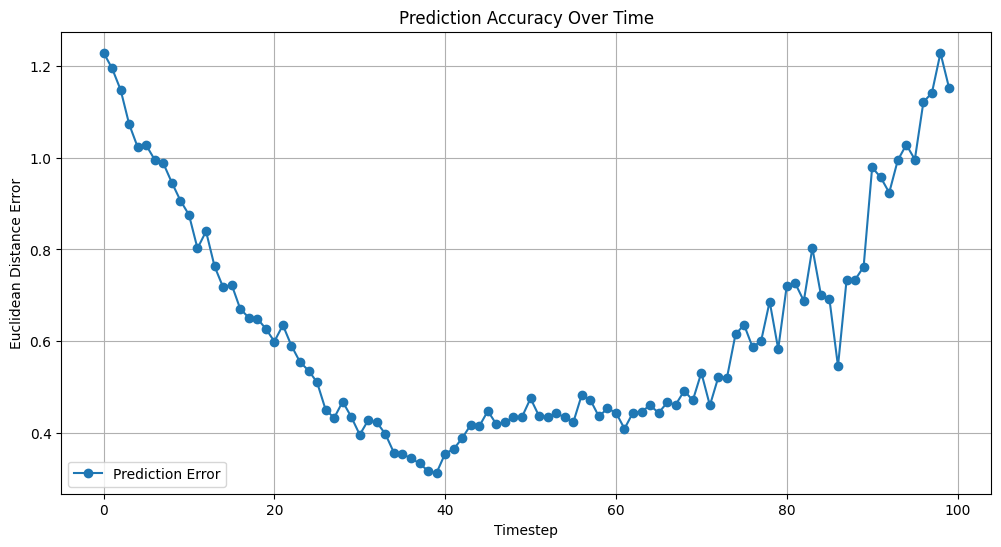

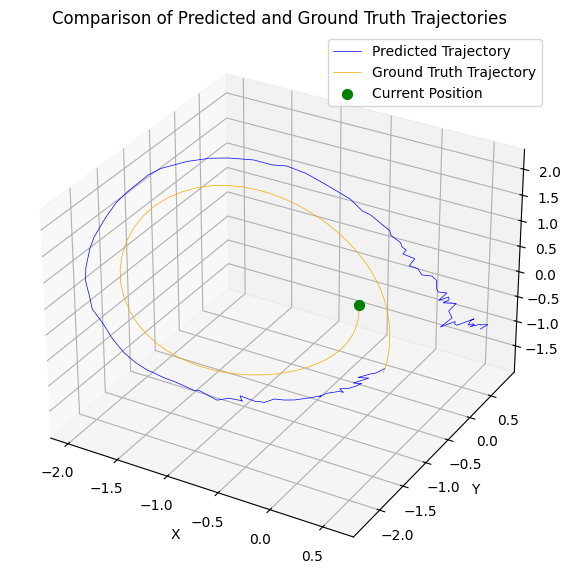

Error at Timestep 10: 0.8755
Error at Timestep 50: 0.4756
Error at Timestep 100: 1.1523


In [ ]:
# Example current point
current_point = data[-100]  # Starting from a specific point in the original dataset

# Predicted future trajectory (from your VAE-RNN)
predicted_trajectory = predict_future(vae_rnn, initial_sequence, steps=100)

# Ground truth trajectory for the same future period
ground_truth = data[-100:]  # The next 100 steps from the original data

# Evaluate prediction accuracy
errors = evaluate_prediction_accuracy(current_point=current_point,
                                      predicted_trajectory=predicted_trajectory,
                                      ground_truth=ground_truth,
                                      max_timesteps=100)

# Print errors at specific timesteps
print(f"Error at Timestep 10: {errors[10]:.4f}")
print(f"Error at Timestep 50: {errors[50]:.4f}")
print(f"Error at Timestep 100: {errors[-1]:.4f}")


Largest Lyapunov Exponent (λ₁): 0.4002


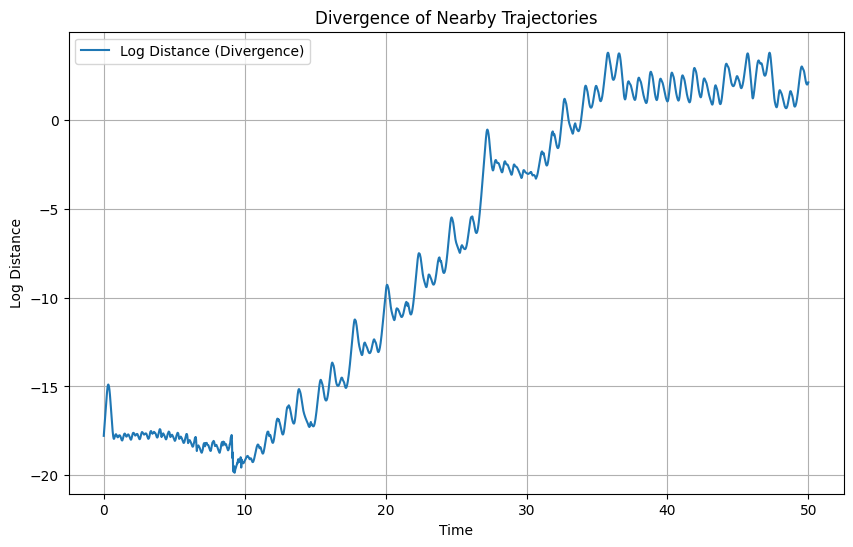

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Lorenz system equations
def lorenz(t, state, sigma=10, beta=8/3, rho=28):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Parameters
t_span = (0, 50)  # Simulation time
dt = 0.01         # Time step
t_eval = np.arange(t_span[0], t_span[1], dt)

# Initial conditions
initial_state = np.array([1.0, 1.0, 1.0])
perturbation = 1e-8  # Small perturbation for nearby trajectory

# Generate the main trajectory
solution_main = solve_ivp(lorenz, t_span, initial_state, t_eval=t_eval)
trajectory_main = solution_main.y.T  # Shape: (timesteps, 3)

# Generate the perturbed trajectory
initial_perturbed = initial_state + perturbation
solution_perturbed = solve_ivp(lorenz, t_span, initial_perturbed, t_eval=t_eval)
trajectory_perturbed = solution_perturbed.y.T  # Shape: (timesteps, 3)

# Measure divergence between trajectories
distances = np.linalg.norm(trajectory_main - trajectory_perturbed, axis=1)

# Normalize distances periodically
log_divergence = []
for i in range(1, len(distances)):
    if distances[i] < 1e-5 or distances[i] > 1e2:
        # Rescale perturbed trajectory
        direction = (trajectory_perturbed[i] - trajectory_main[i]) / distances[i]
        trajectory_perturbed[i] = trajectory_main[i] + perturbation * direction
        solution_perturbed = solve_ivp(
            lorenz, t_span, trajectory_perturbed[i], t_eval=t_eval[i:]
        )
        trajectory_perturbed[i:] = solution_perturbed.y.T
    log_divergence.append(np.log(distances[i] / distances[i - 1]))

# Compute the largest Lyapunov exponent
lyapunov_exponent = np.mean(log_divergence) / dt
print(f"Largest Lyapunov Exponent (λ₁): {lyapunov_exponent:.4f}")

# Plot divergence over time
plt.figure(figsize=(10, 6))
plt.plot(t_eval[1:], np.log(distances[1:]), label="Log Distance (Divergence)")
plt.xlabel("Time")
plt.ylabel("Log Distance")
plt.title("Divergence of Nearby Trajectories")
plt.legend()
plt.grid()
plt.show()
